## Plot Wflow results and observed discharge for Santa Lucia

In [1]:
import os
import matplotlib.pyplot as plt
import hydromt
from hydromt_wflow import WflowModel
import numpy as np

plt.style.use("default")
from matplotlib.ticker import ScalarFormatter

Create a python dict to list the root location of the wflow model

In [2]:
# Dictionary listing the different wflow models and runs to compare, including plotting options (in this example only 1 ru
runs = {
    "run1": {
        "longname": "Q_sim",
        "color": "blue",
        "root": "d:/Documentos/Python Scripts/wflow_santalucia/daily_initial",
        "config_fn": "wflow_sbm.toml",
    },
}
mainrun = "run1"

Initialize the different model run(s)

In [3]:
# Initialize the different model run(s)
for r in runs:
    run = runs[r]
    mod = WflowModel(root=run["root"], mode="r", config_fn=run["config_fn"])
    runs[r].update({"mod": mod})

In [4]:
mod1 = runs["run1"]["mod"]
mod1.results

{'output': <xarray.Dataset>
 Dimensions:  (lon: 364, lat: 197, layer: 4, time: 5114)
 Coordinates:
   * lon      (lon) float64 -57.1 -57.1 -57.09 -57.09 ... -55.0 -54.99 -54.99
   * lat      (lat) float64 -34.84 -34.84 -34.83 -34.83 ... -33.71 -33.71 -33.7
   * layer    (layer) float64 1.0 2.0 3.0 4.0
   * time     (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2020-12-31
 Data variables:
     q_river  (time, lat, lon) float32 dask.array<chunksize=(30, 197, 364), meta=np.ndarray>,
 'Q_gauges': <xarray.DataArray 'Q_gauges' (index: 1, time: 5114)>
 array([[1.94329329e-04, 1.22556614e-03, 2.37485782e-03, ...,
         5.26400003e-01, 4.49965083e-01, 4.56045426e-01]])
 Coordinates:
   * time         (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2020-12-31
   * index        (index) int32 1
     geometry     (index) object POINT (-56.387083333333095 -34.797083333333674)
     value        (index) float64 1.0
     spatial_ref  int32 0,
 'Q_grdc_gauges_grdc': <xarray.DataArray 'Q_grdc_gauges

## Read Observations

In this section we'll create an python function to allow to read the observed time series from a csv file location in obs folder

In [5]:
import pandas as pd
import numpy as np
import xarray as xr

def timeseries_from_csv(fn, name=None, index_dim="index", dayfirst=False, **kwargs):
    kwargs0 = dict(index_col=0, parse_dates=True, dayfirst=dayfirst)
    kwargs0.update(**kwargs)
    df = pd.read_csv(fn, **kwargs0)
    # check if time index
    if np.dtype(df.index).type != np.datetime64:
        try:
            df.columns = pd.to_datetime(df.columns)
            df = df.T
        except ValueError:
            raise ValueError(f"No time index found in file: {fn}")
    # try parsing column index to integers
    if isinstance(df.columns[0], str):
        try:
            df.columns = [int("".join(filter(str.isdigit, n))) for n in df.columns]
            assert df.columns.size == np.unique(df.columns).size
        except (ValueError, AssertionError):
            raise ValueError(f"No numeric index found in file: {fn}")
    df.columns.name = index_dim
    name = name if name is not None else basename(fn).split(".")[0]
    return xr.DataArray(df, dims=("time", index_dim), name=name)

In [6]:
# Discharge data
timeseries_fn = r"d:\Documentos\Python Scripts\wflow_santalucia\obs\wflowsantalucia_obs_naturalizados.csv"  # observed discharge timeseries
name = "gauges_dinagua"  # gauges locations in staticgeoms
stationID = "ID"  # column name in staticgeoms containing the stations IDs

# Read the observations data
# read timeseries data and match with existing gdf
gdf = runs[mainrun]["mod"].staticgeoms[name]
gdf.index = gdf[stationID]
da_ts = timeseries_from_csv(timeseries_fn, name=name, sep=",", dayfirst=True)

da = hydromt.vector.GeoDataArray.from_gdf(gdf, da_ts, index_dim="index")

obs = da
obs

<xarray.DataArray 'gauges_dinagua' (index: 7, time: 4566)>
array([[ 12.77,  12.7 ,  12.48, ..., 125.3 , 166.89, 205.66],
       [  2.27,   2.17,   2.07, ...,  97.55, 184.74, 198.67],
       [  0.9 ,   0.87,   0.84, ...,    nan,    nan,    nan],
       ...,
       [  0.6 ,   0.58,   0.54, ..., 186.07, 134.36,  85.73],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [  0.43,   0.43,   0.41, ...,  10.73,  12.41,  14.87]])
Coordinates:
  * time             (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2021-07-02
  * index            (index) int64 1330 591 1150 1170 440 1190 531
    ID               (index) int64 1330 591 1150 1170 440 1190 531
    nombre estacion  (index) object 'Santa Lucia (Ruta 11)' ... 'Florida (Pue...
    cod est          (index) float64 133.0 59.1 115.0 117.0 44.0 119.0 53.1
    elevacion        (index) object '2.27 (m cero Wharton)' ... '44.34 (m cer...
    geometry         (index) object POINT (-56.39875 -34.44708333333333) ... ...
    spatial_ref      int32 0

As an example, we'll plot the discharge data from Fray Marcos Station

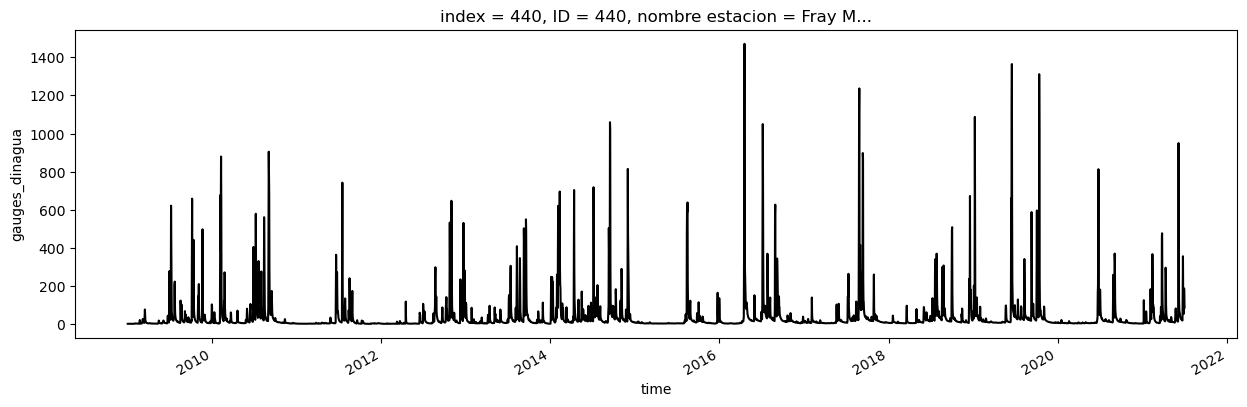

In [7]:
# Plot the observed discharge timeseries
st = 440
n = 1

fig, axes = plt.subplots(n, 1, sharex=True, figsize=(15, n * 4))
axes = [axes] if n == 1 else axes

# Discharge
obs_i = obs.sel(index=st)
obs_i.plot.line(ax=axes[0], x="time", label="obs", color="black");

## Read Forcing

In [8]:
forcing_csv = r"d:\Documentos\Python Scripts\wflow_santalucia\daily_initial\run_default\output.csv"
precip_ts = pd.read_csv(forcing_csv,index_col="time",usecols=lambda col: col.startswith('P_dinagua_subc_') or col.startswith('time'))
etp_ts = pd.read_csv(forcing_csv,index_col="time",usecols=lambda col: col.startswith('PET_dinagua_subc_') or col.startswith('time'))
eta_ts = pd.read_csv(forcing_csv,index_col="time",usecols=lambda col: col.startswith('AET_dinagua_subc_') or col.startswith('time'))
recharge_ts = pd.read_csv(forcing_csv,index_col="time",usecols=lambda col: col.startswith('RECHARGE_dinagua_subc') or col.startswith('time'))

In [9]:
precip_ts.index = pd.to_datetime(precip_ts.index).strftime('%Y-%m-%d %H:%M')
etp_ts.index = pd.to_datetime(etp_ts.index).strftime('%Y-%m-%d %H:%M')
eta_ts.index = pd.to_datetime(eta_ts.index).strftime('%Y-%m-%d %H:%M')
recharge_ts.index = pd.to_datetime(recharge_ts.index).strftime('%Y-%m-%d %H:%M')

In [10]:
# Plotting options
# select the Dinagua gauges results (note: you can find the name in the output of mod1.results, a few cells above)
result_name = "Q_dinagua_gauges_dinagua"

# selection of runs to plot (all or a subset) (in this example, we only defined 1 run)
runs_subset = ["run1"]

In [11]:
# Define start and enddate
startDate = '2009-01-01 00:00'
endDate = '2020-12-31 00:00'

# Define Dinagua Station Ids
station_ids = list(runs[mainrun]["mod"].results[result_name].index.values)

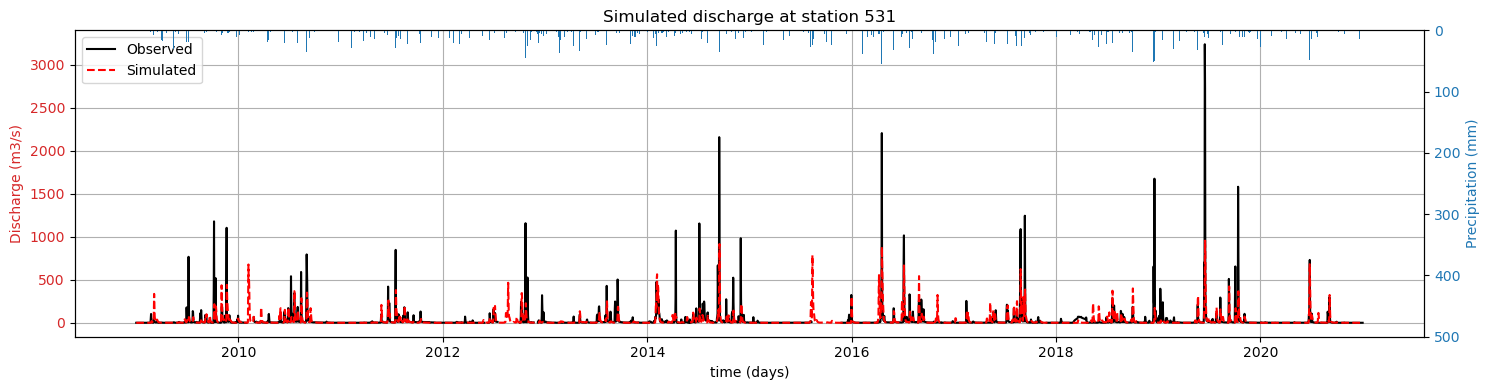

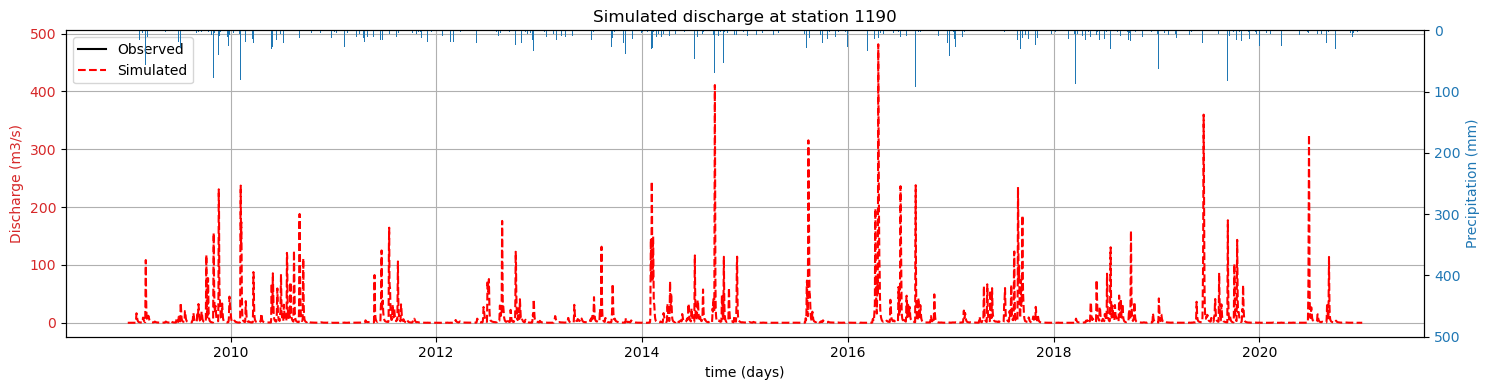

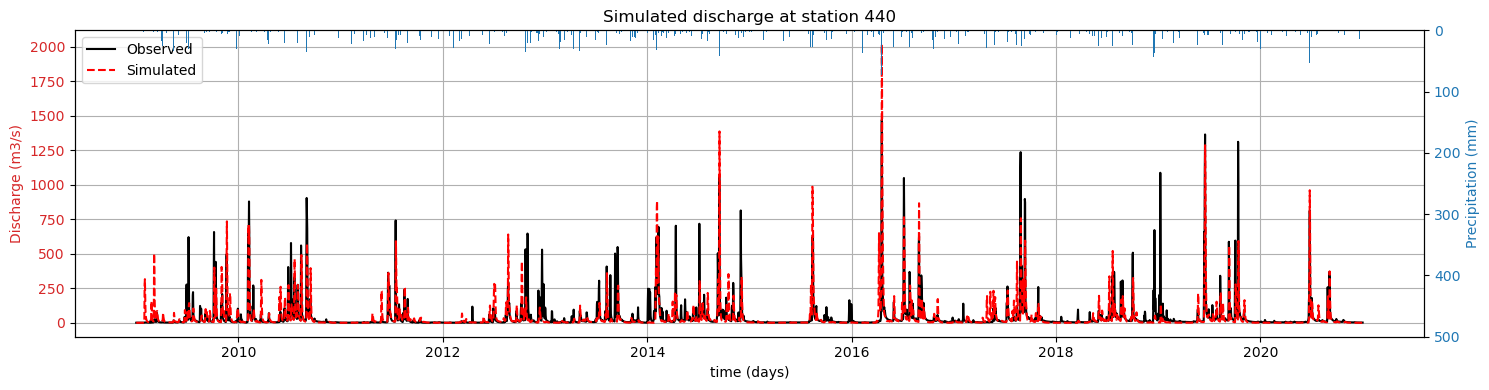

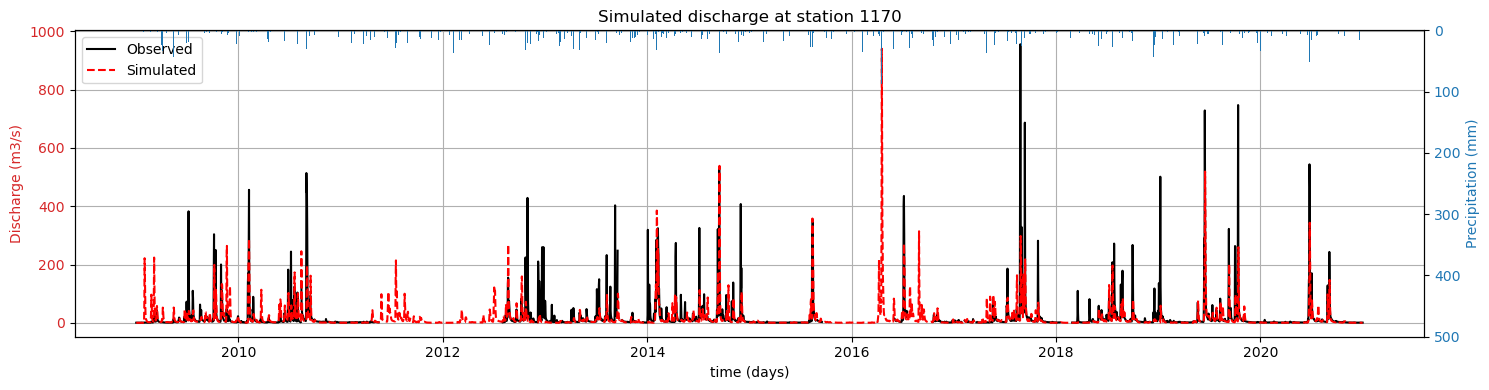

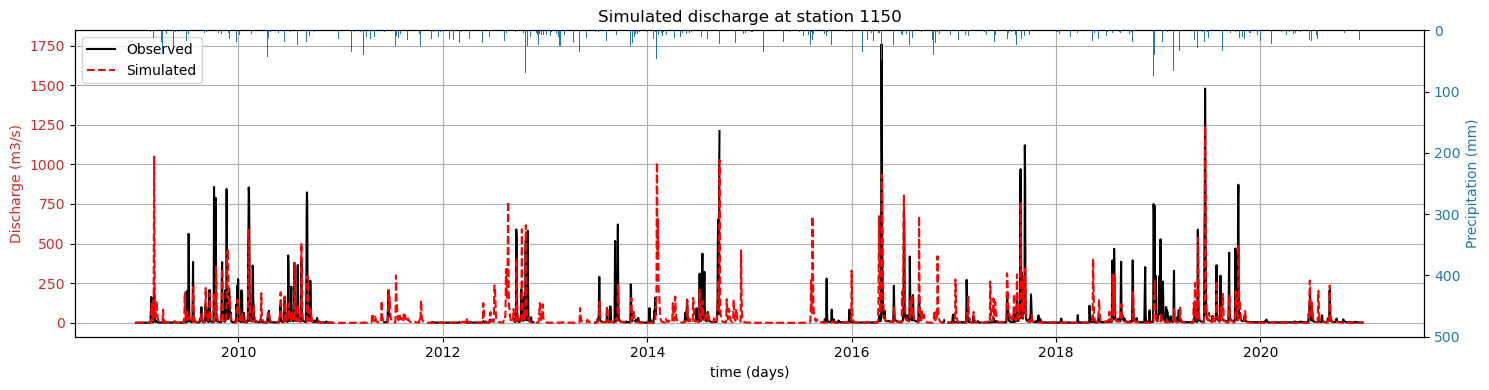

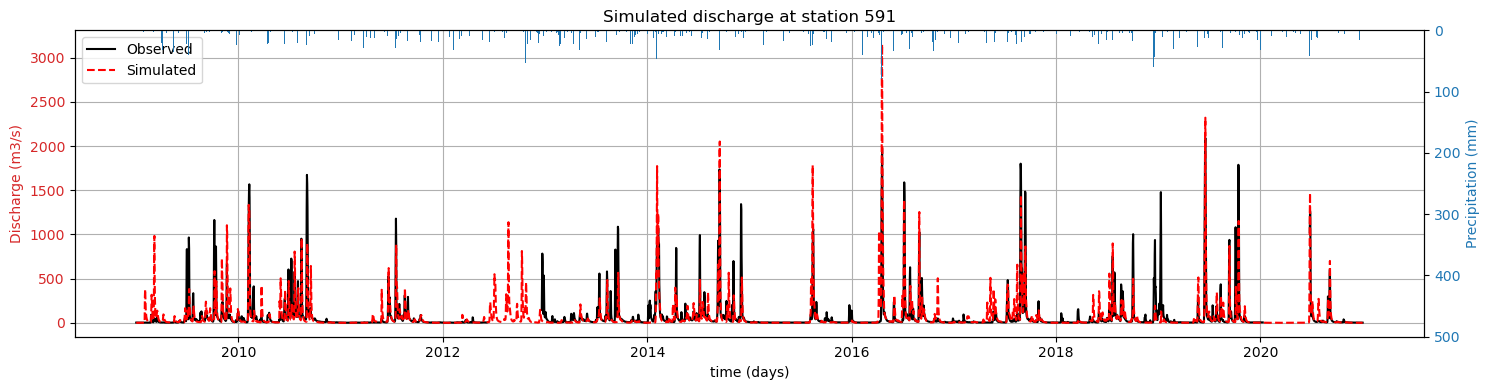

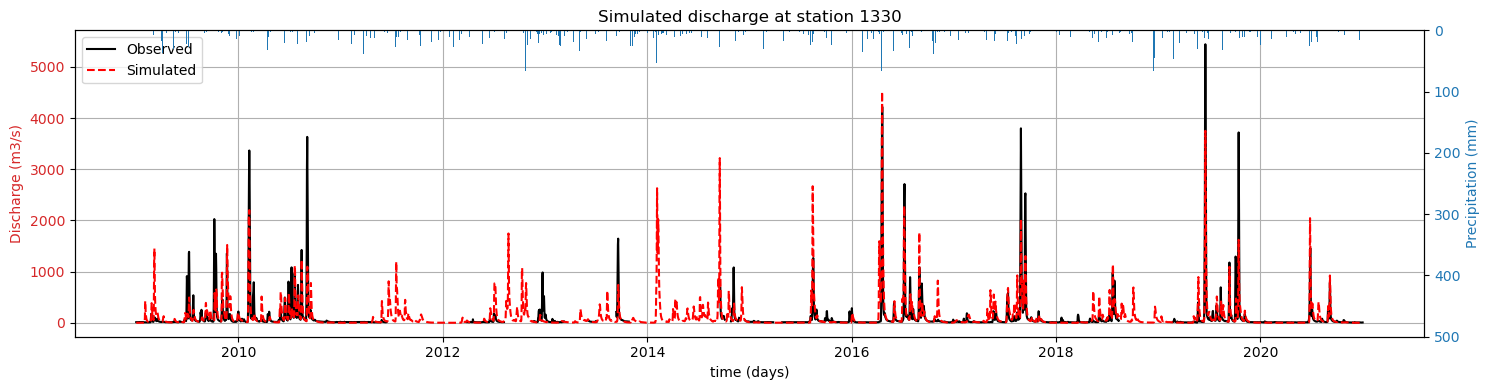

In [12]:
for i, st in enumerate(station_ids):
    fig, ax1 = plt.subplots(figsize=(15, 4))
    color = 'tab:red'
    # Discharge
    obs_i = obs.sel(index=st)
    # Precip 
    col_name = f"P_dinagua_subc_{st}"
    precip = pd.DataFrame(precip_ts.loc[startDate:endDate][col_name])
    # Plot modelled & observed discharge
    for r in runs_subset:
        run = runs[r]
        run_i = run["mod"].results[result_name].sel(index=st)
        qsim = run_i.to_dataframe()
        qobs = obs_i.to_dataframe()
        qobs = qobs.loc[startDate:endDate]
        qsim = qsim.loc[startDate:endDate]
        ax1.set_xlabel('time (days)')
        ax1.set_ylabel('Discharge (m3/s)', color=color)
        ax1.plot(qobs.index,qobs['gauges_dinagua'],color='k',label='Observed')
        ax1.plot(qsim.index,qsim['Q_dinagua_gauges_dinagua'],color='r',linestyle="--",label='Simulated')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_title(f"Simulated discharge at station {st}")
        ax1.grid()
        ax1.legend('Obs','Simulated',loc="upper left")
        
        ax2 = ax1.twinx() 

        color = 'tab:blue'
        ax2.set_ylabel('Precipitation (mm)', color=color) 
        ax2.bar(qsim.index,precip[col_name].values,color=color)
        ax2.set_ylim(0,500)
        ax2.invert_yaxis()
        ax2.tick_params(axis='y', labelcolor=color)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped

        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc=2)
        plt.show()

# Plot Observed vs simulated (with metrics)

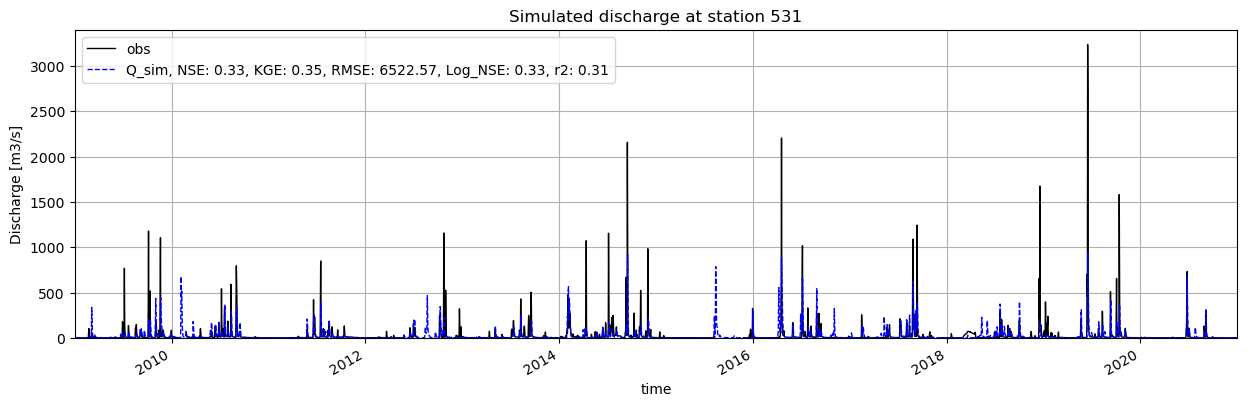

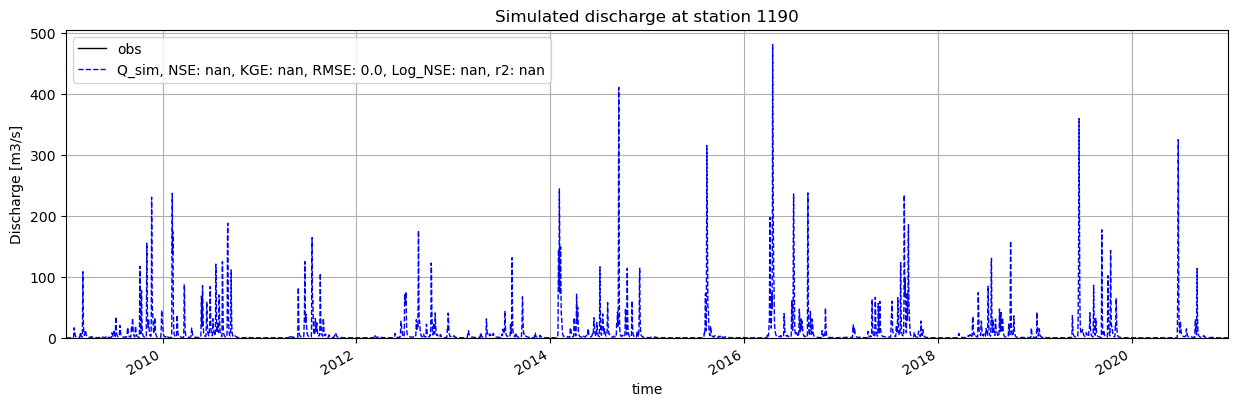

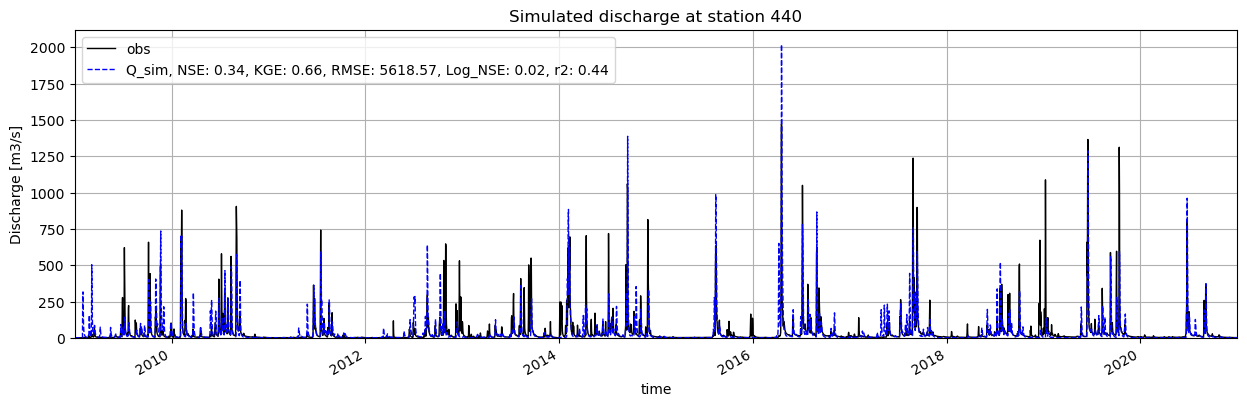

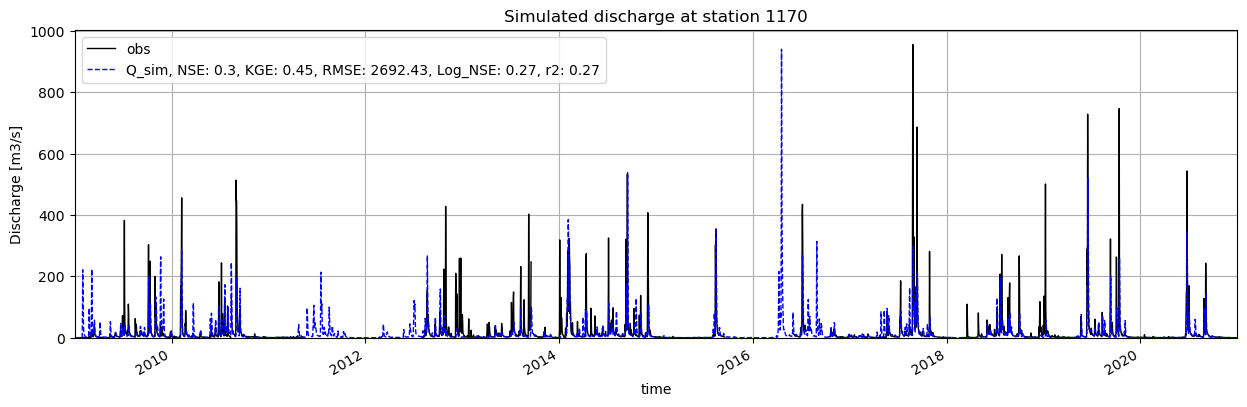

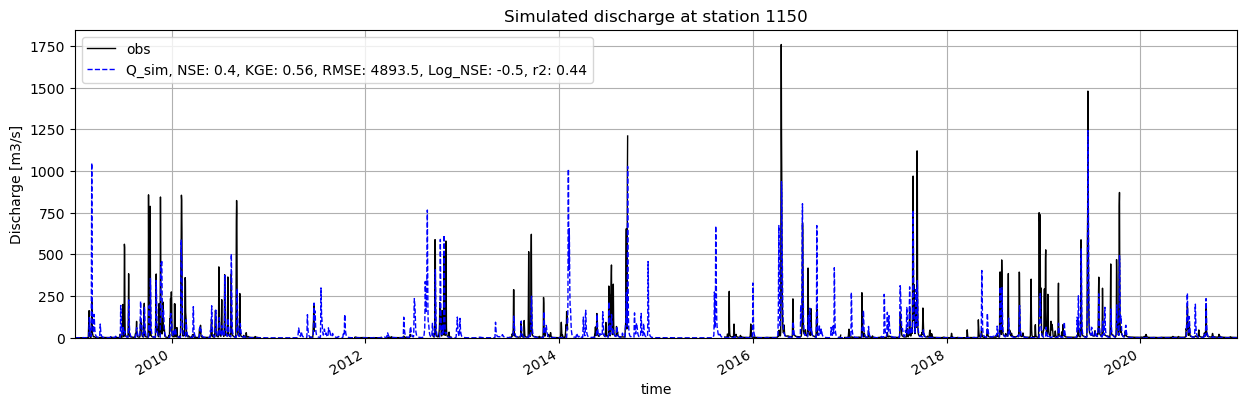

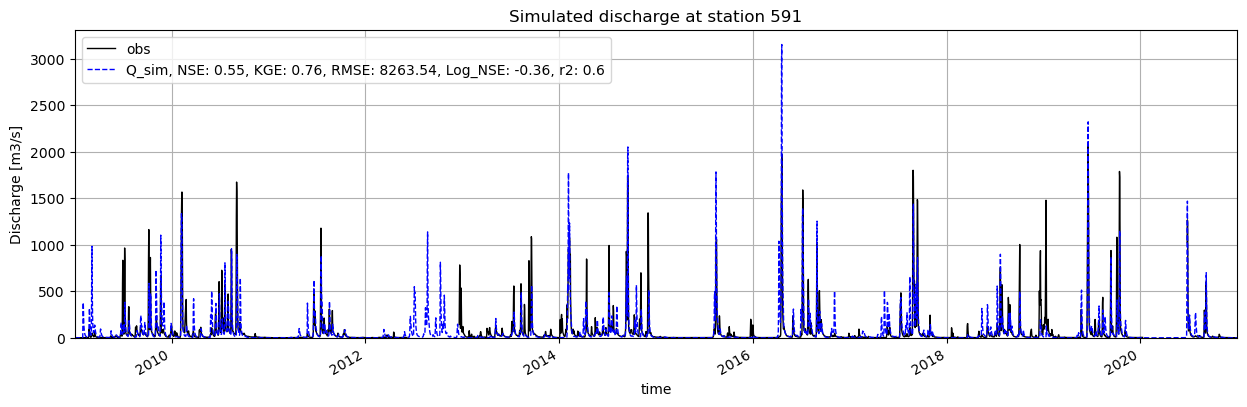

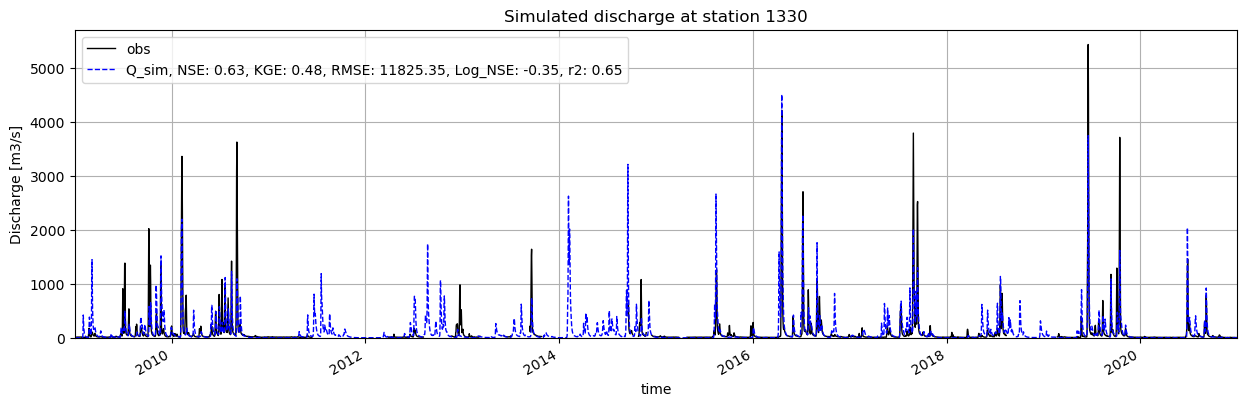

In [13]:
# Create and save figures with plots
# Note: if you align time axes & resample to same time unit, you can also calculate skill scores with hydromt:
from hydromt.stats import skills as skillstats
# from hydromt import stats as skillstats  # for hydromt < v0.4.5

# outdir = os.path.join(mod.root, "figs")
# os.makedirs(outdir, exist_ok=True)

for i, st in enumerate(station_ids):
    n = 1
    fig, axes = plt.subplots(n, 1, sharex=True, figsize=(15, n * 4))
    axes = [axes] if n == 1 else axes

    # Discharge
    obs_i = obs.sel(index=st)
    obs_i.plot.line(ax=axes[0], x="time", label="obs", color="black", linewidth=1)

    # Plot modelled & observed discharge
    for r in runs_subset:
        run = runs[r]
        run_i = run["mod"].results[result_name].sel(index=st)
        # Stats
        # Note: if you align time axes & resample to same time unit, you can also calculate skill scores with hydromt:
        obs_i, run_i = xr.align(obs_i, run_i)
        nse_i = skillstats.nashsutcliffe(run_i, obs_i).values.round(2)
        kge_i = skillstats.kge(run_i, obs_i)["kge"].values.round(2)
        rmse_i = skillstats.rmse(run_i, obs_i).values.round(2)
        lognse_i = skillstats.lognashsutcliffe(run_i, obs_i).values.round(2)
        r2_i = skillstats.rsquared(run_i, obs_i).values.round(2)
        labeltxt = f"{run['longname']}, NSE: {nse_i}, KGE: {kge_i}, RMSE: {rmse_i}, Log_NSE: {lognse_i}, r2: {r2_i}"
        # labeltxt = f"{run['longname']}"
        run_i.plot.line(
            ax=axes[0],
            x="time",
            label=labeltxt,
            color=f"{run['color']}",
            linestyle="--",
            linewidth=1
        )

    axes[0].set_xlim(pd.to_datetime(startDate), pd.to_datetime(endDate))
    axes[0].set_ylim(0,)
    axes[0].grid()

    axes[0].legend(loc='upper left')
    axes[0].set_title(f"Simulated discharge at station {st}")
    axes[0].set_ylabel("Discharge [m3/s]")
    axes[0].legend()

    # Save figures
    # fn_out = os.path.join(outdir, f"results-{st}.png")
    # fig.savefig(fn_out, dpi=225, bbox_inches="tight")

# Scatter plot between Obs and Sim

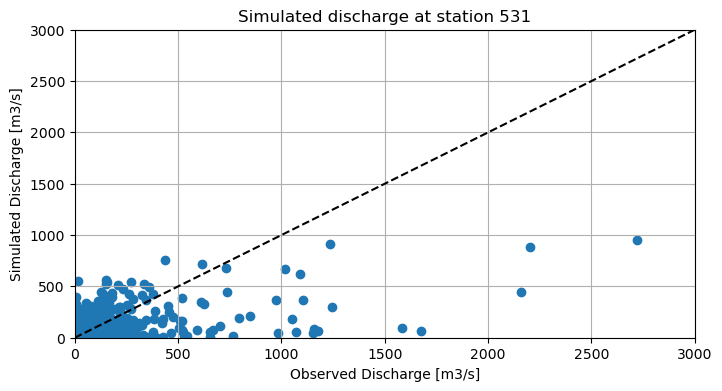

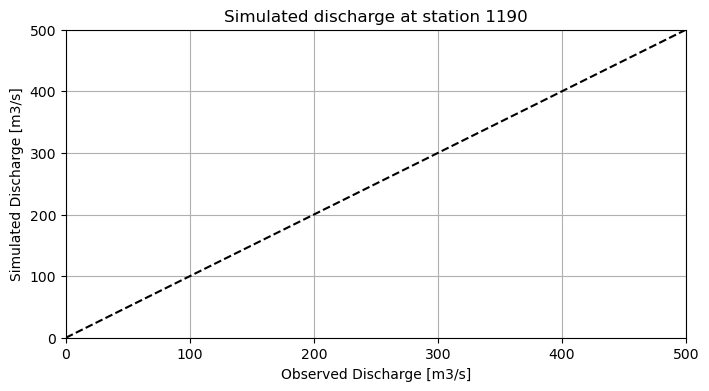

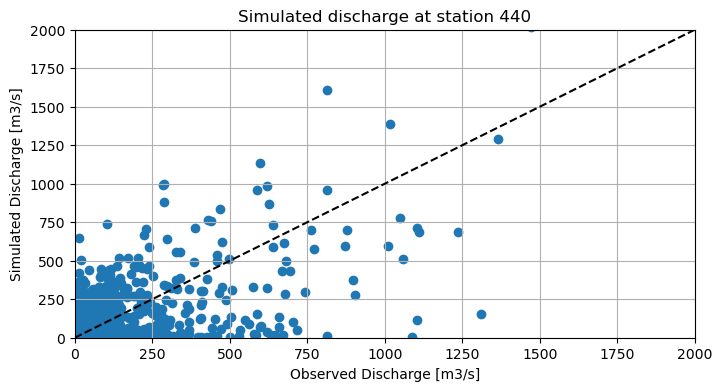

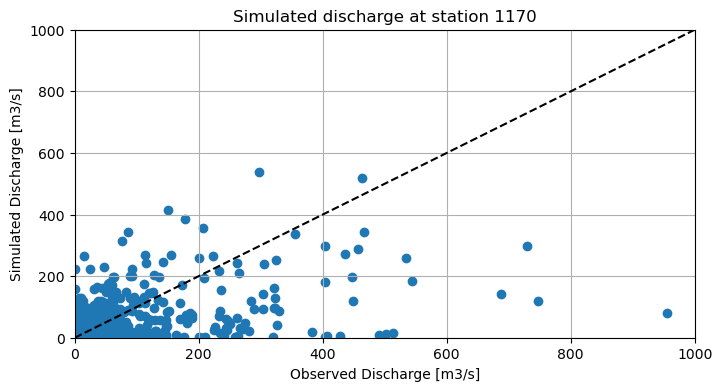

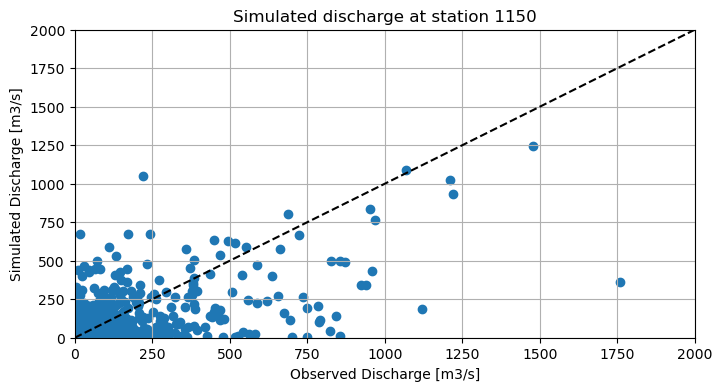

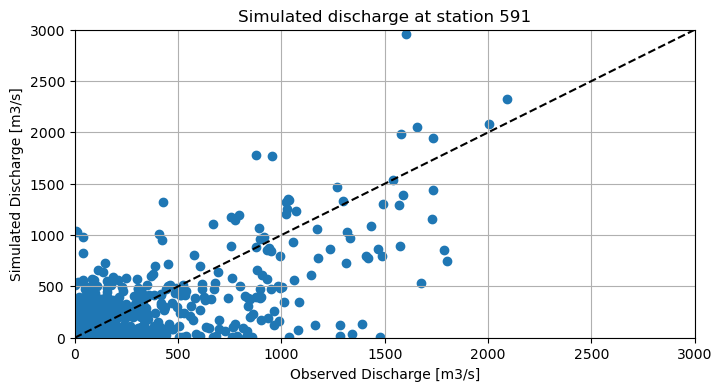

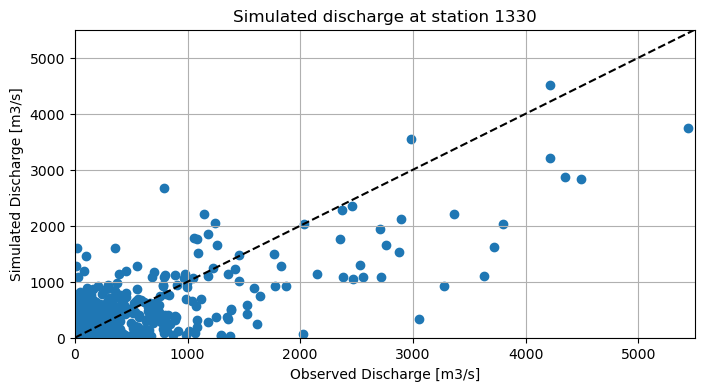

In [14]:
# Create and save figures with plots

outdir = os.path.join(mod.root, "figs")
os.makedirs(outdir, exist_ok=True)

for i, st in enumerate(station_ids):
    n = 1
    fig, axes = plt.subplots(n, 1, sharex=True, figsize=(8, n * 4))
    axes = [axes] if n == 1 else axes

    # Discharge
    obs_i = obs.sel(index=st)

    # Plot modelled & observed discharge
    for r in runs_subset:
        run = runs[r]
        run_i = run["mod"].results[result_name].sel(index=st)
        qsim = run_i.to_dataframe()
        qobs = obs_i.to_dataframe()
        qobs = qobs.loc[startDate:endDate]
        qsim = qsim.loc[startDate:endDate]
        plt.scatter(qobs['gauges_dinagua'],qsim['Q_dinagua_gauges_dinagua'])
        plt.axline([0, 0], [1, 1],linestyle='--', color='k')
        max_obs = qobs['gauges_dinagua'].max(numeric_only = True)  
        if np.isnan(max_obs):
            max_obs = 0
        else:
            max_obs = round(max_obs/500)*500
        
        max_sim = qsim['Q_dinagua_gauges_dinagua'].max(numeric_only = True)
        max_sim = round(max_sim/500)*500

    axes[0].set_xlim(0,max(max_obs,max_sim))
    axes[0].set_ylim(0,max(max_obs,max_sim))
    axes[0].grid()

    axes[0].set_title(f"Simulated discharge at station {st}")
    axes[0].set_ylabel("Simulated Discharge [m3/s]")
    axes[0].set_xlabel("Observed Discharge [m3/s]")

    # Save figures
    fn_out = os.path.join(outdir, f"results-{st}.png")
    # fig.savefig(fn_out, dpi=225, bbox_inches="tight")

# Residual error plot

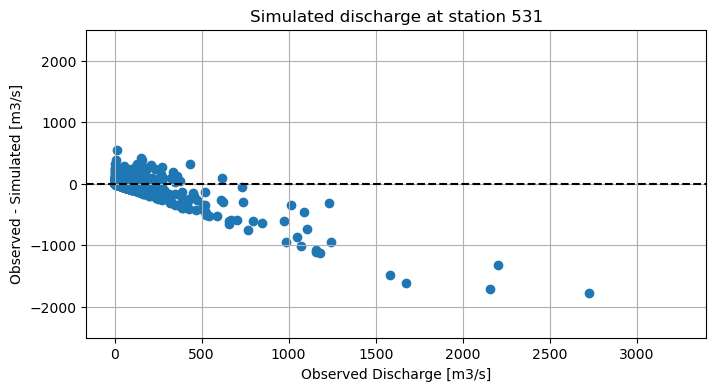

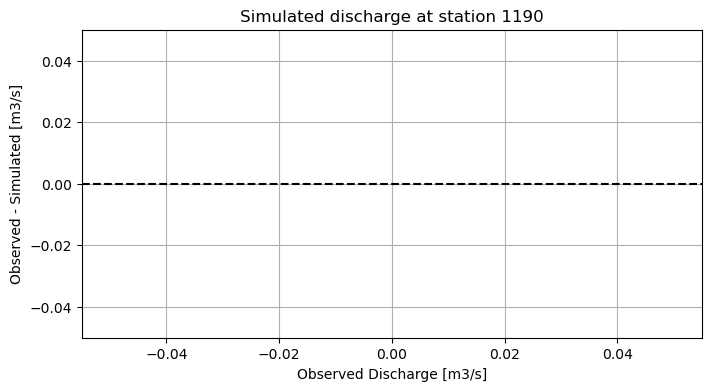

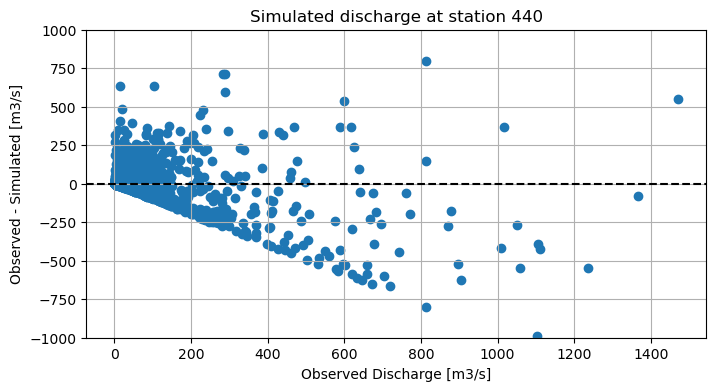

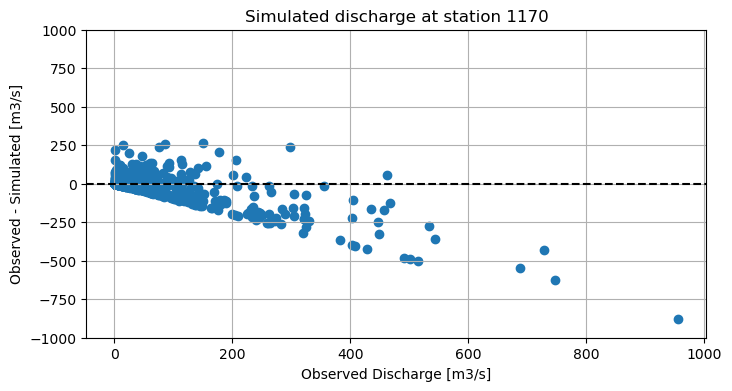

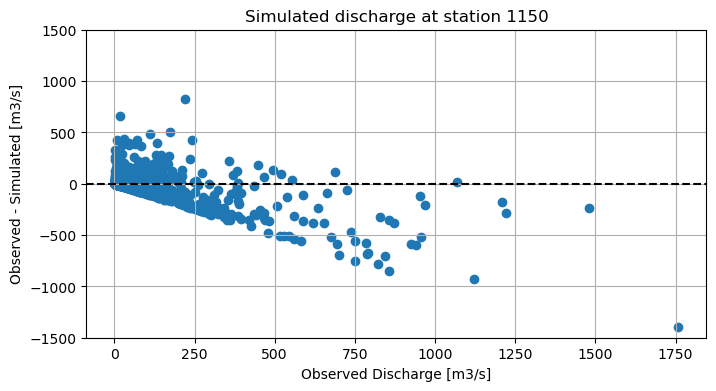

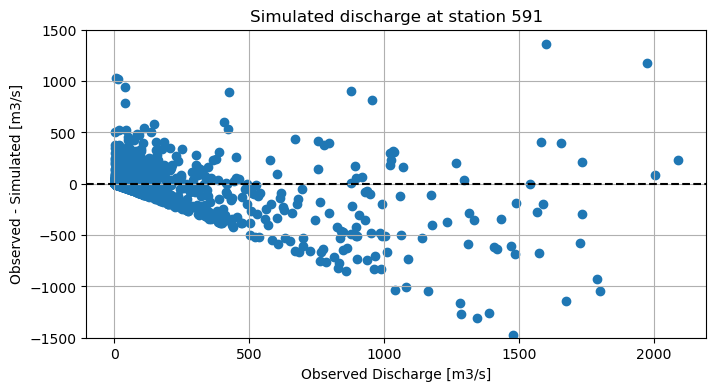

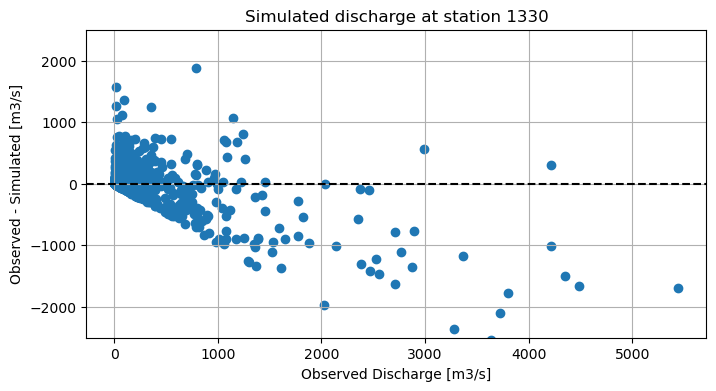

In [15]:
# Create and save figures with plots
outdir = os.path.join(mod.root, "figs")
os.makedirs(outdir, exist_ok=True)

for i, st in enumerate(station_ids):
    n = 1
    fig, axes = plt.subplots(n, 1, sharex=True, figsize=(8, n * 4))
    axes = [axes] if n == 1 else axes

    # Discharge
    obs_i = obs.sel(index=st)

    # Plot modelled & observed discharge
    for r in runs_subset:
        run = runs[r]
        run_i = run["mod"].results[result_name].sel(index=st)
        qsim = run_i.to_dataframe()
        qobs = obs_i.to_dataframe()
        qobs = qobs.loc[startDate:endDate]
        qsim = qsim.loc[startDate:endDate]
        wflowModelerror = qsim['Q_dinagua_gauges_dinagua'] - qobs['gauges_dinagua']
        plt.scatter(qobs['gauges_dinagua'],wflowModelerror)
        max_e = np.nanmax(wflowModelerror)
        min_e = np.nanmin(wflowModelerror)
        if np.isnan(max_e):
            max_e = 0
            min_e = 0
        else:
            max_e = round(max_e/500)*500
            min_e = round(min_e/500)*500

        if max_e > np.negative(min_e):
            lim_e = max_e
        else:
            lim_e = np.negative(min_e)
        
        plt.axhline(y=0,linestyle='--', color='k')

    #axes[0].set_xlim(0,max(max_obs,max_sim))
    # axes[0].set_ylim(-3000,3000)
    axes[0].set_ylim(np.negative(lim_e),lim_e)
    axes[0].grid()

    axes[0].set_title(f"Simulated discharge at station {st}")
    axes[0].set_ylabel("Observed - Simulated [m3/s]")
    axes[0].set_xlabel("Observed Discharge [m3/s]")

    # Save figures
    # fn_out = os.path.join(outdir, f"results-{st}.png")
    # fig.savefig(fn_out, dpi=225, bbox_inches="tight")

# Flow Duration Curve

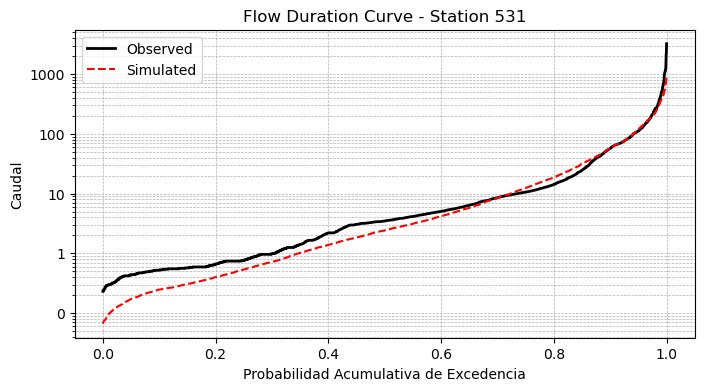

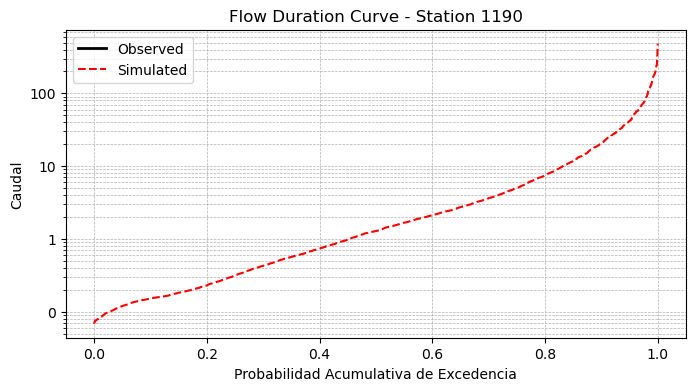

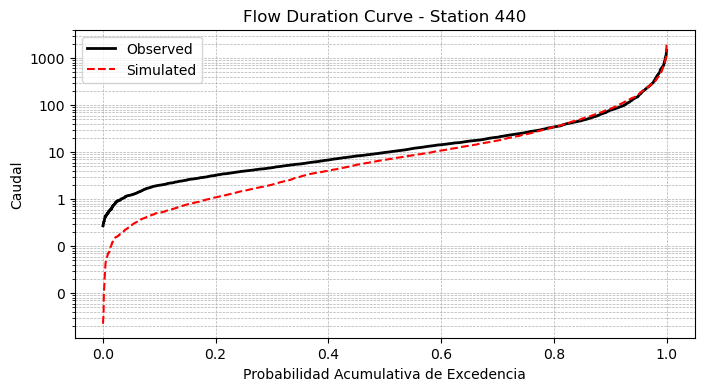

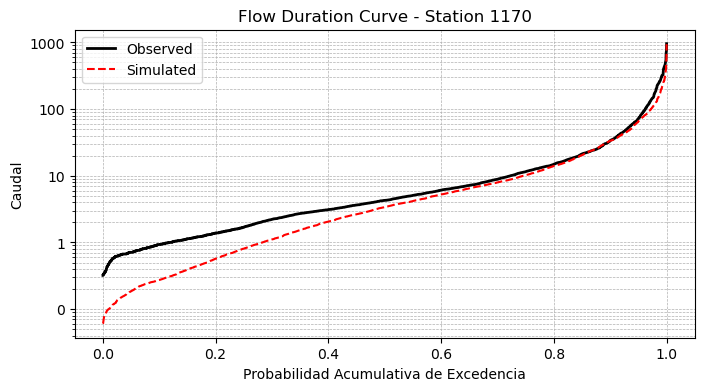

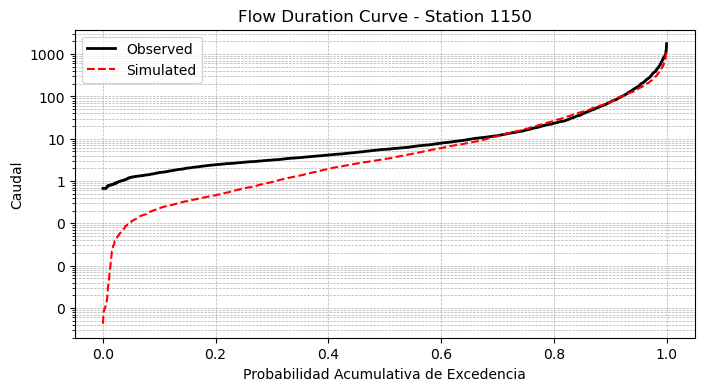

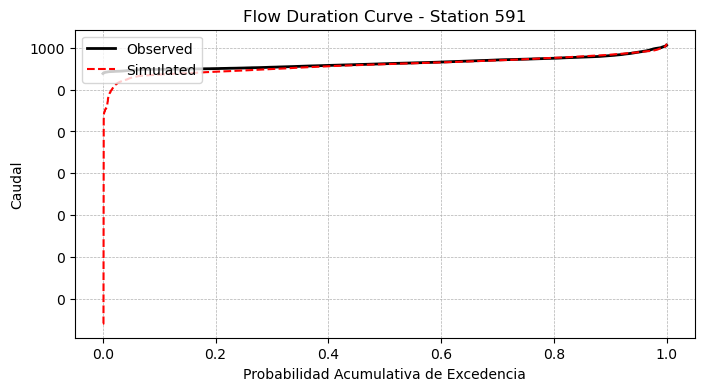

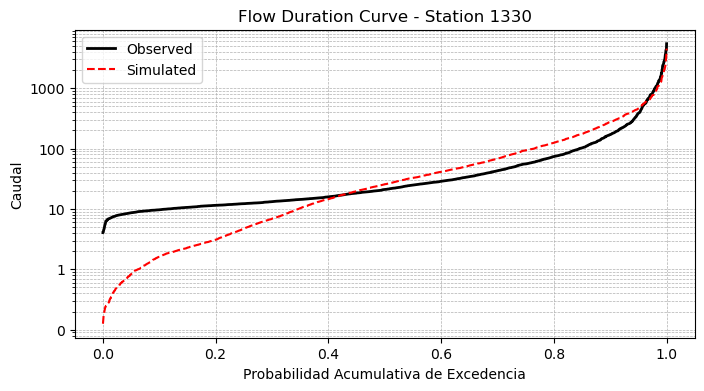

In [16]:
# Create and save figures with plots

outdir = os.path.join(mod.root, "figs")
os.makedirs(outdir, exist_ok=True)

for i, st in enumerate(station_ids):
    n = 1
    fig, axes = plt.subplots(n, 1, sharex=True, figsize=(8, n * 4))
    axes = [axes] if n == 1 else axes

    # Discharge
    obs_i = obs.sel(index=st)

    # Plot modelled & observed discharge
    for r in runs_subset:
        run = runs[r]
        run_i = run["mod"].results[result_name].sel(index=st)
        qsim = run_i.to_dataframe()
        qobs = obs_i.to_dataframe()
        qobs = qobs.loc[startDate:endDate]
        qsim = qsim.loc[startDate:endDate]
        obs_sorted = qobs.dropna(subset=['gauges_dinagua']).sort_values(by='gauges_dinagua')
        x_obs = np.linspace(0, 1, len(obs_sorted))
        # Simulated
        sim_sorted = qsim.sort_values(by='Q_dinagua_gauges_dinagua')
        x_sim = np.linspace(0, 1, len(sim_sorted))
        # plot 
        plt.semilogy(x_obs, obs_sorted['gauges_dinagua'], color='k',linestyle="-",lw=2,label='Observed');
        plt.semilogy(x_sim, sim_sorted['Q_dinagua_gauges_dinagua'], color='r',linestyle="--",label='Simulated');
        # Configuración del formateador del eje y para desactivar la notación científica
    plt.gca().yaxis.set_major_formatter(ScalarFormatter())
    plt.title(f'Flow Duration Curve - Station {st}');
    plt.ylabel('Caudal');
    plt.xlabel('Probabilidad Acumulativa de Excedencia');
    plt.grid(which='both', linestyle='--', linewidth=0.5);
    plt.legend(loc="upper left")
    plt.show();

    # Save figures
    # fn_out = os.path.join(outdir, f"results-{st}.png")
    # fig.savefig(fn_out, dpi=225, bbox_inches="tight")

# Select observation and simulation from a single station

In [17]:
print(f"Please select one of the following stations: {', '.join(list(map(str, station_ids)))}")

Please select one of the following stations: 531, 1190, 440, 1170, 1150, 591, 1330


In [18]:
st = 531

Extract data from station id and time range

In [19]:
qsim_metrics = run["mod"].results[result_name].sel(index=st,time=slice(startDate,endDate))
qobs_metrics = obs.sel(index=st,time=slice(startDate,endDate))
# Convert to datafrme
df_qsim = qsim_metrics.to_dataframe()
df_qobs = qobs_metrics.to_dataframe()

Merge two dataframe (obs and sim) and export it to csv

In [20]:
merged_df = df_qsim[['Q_dinagua_gauges_dinagua']].merge(df_qobs[['gauges_dinagua']], left_index=True, right_index=True)
# merged_df.to_csv('model_result.csv', index=True, na_rep='NaN')

## Calculate metrics

In [21]:
kge = skillstats.kge(qsim_metrics, qobs_metrics)['kge'].values.round(2)
print(f'the kge is: {kge}')
rmse = skillstats.rmse(qsim_metrics, qobs_metrics).values.round(2)
print(f'the rmse is: {rmse}')
ns = skillstats.nashsutcliffe(qsim_metrics, qobs_metrics).values.round(2)
print(f'the nash sutcliffe is: {ns}')
log_ns = skillstats.lognashsutcliffe(qsim_metrics, qobs_metrics).values.round(2)
print(f'the log-NashSutcliffe is: {log_ns}')
r2 = skillstats.rsquared(qsim_metrics, qobs_metrics).values.round(2)
print(f'the R2 is: {r2}')

the kge is: 0.35
the rmse is: 6522.57
the nash sutcliffe is: 0.33
the log-NashSutcliffe is: 0.33
the R2 is: 0.31


## Single Flow Duration Curve

In [22]:
# Observed
obs_sorted = df_qobs.dropna(subset=['gauges_dinagua']).sort_values(by='gauges_dinagua')
x_obs = np.linspace(0, 1, len(obs_sorted))
# Simulated
sim_sorted = df_qsim.sort_values(by='Q_dinagua_gauges_dinagua')
x_sim = np.linspace(0, 1, len(sim_sorted))

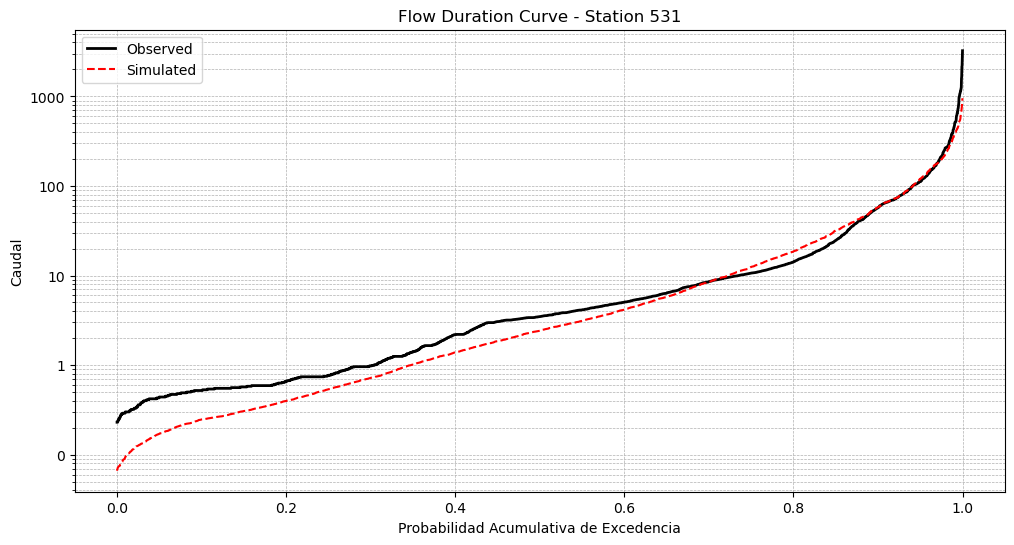

In [23]:

plt.figure(figsize=(12, 6)) 
plt.semilogy(x_obs, obs_sorted['gauges_dinagua'], color='k',linestyle="-",lw=2,label='Observed');
plt.semilogy(x_sim, sim_sorted['Q_dinagua_gauges_dinagua'], color='r',linestyle="--",label='Simulated');
# Configuración del formateador del eje y para desactivar la notación científica
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.title(f'Flow Duration Curve - Station {st}');
plt.ylabel('Caudal');
plt.xlabel('Probabilidad Acumulativa de Excedencia');
plt.grid(which='both', linestyle='--', linewidth=0.5);
plt.legend(loc="upper left")
plt.show();

# Plot all variables

In [24]:
# Precip
col_precip = f"P_dinagua_subc_{st}"
precip = pd.DataFrame(precip_ts.loc[startDate:endDate][col_precip])
# ETR
col_etr = f"AET_dinagua_subc_{st}"
etr = pd.DataFrame(eta_ts.loc[startDate:endDate][col_etr])
# ETP
col_etp = f"PET_dinagua_subc_{st}"
etp = pd.DataFrame(etp_ts.loc[startDate:endDate][col_etp])
# Recharge
col_r = f"RECHARGE_dinagua_subc_{st}"
recharge = pd.DataFrame(recharge_ts.loc[startDate:endDate][col_r])

In [25]:
# Unir todas las variables para llevarlo a matlab

df_all = pd.DataFrame(index=df_qsim.index)
df_all['precip'] = precip[col_precip].values
df_all['etp'] = etp[col_etp].values
df_all['etr'] = etr[col_etr].values
df_all['recharge'] = recharge[col_r].values
df_all['qobs'] = df_qobs['gauges_dinagua'].values
df_all['qsim'] = df_qsim['Q_dinagua_gauges_dinagua'].values

In [26]:
# Exportar el DataFrame fusionado a un archivo CSV
# df_all.to_csv(f'allvariable_station_{st}.csv')

# Water Balance

Define basin areas for each station

In [26]:
area_cuenca_km2 = [1747.60, 690.20, 2759.0, 1078.0, 2346, 4916.0, 8374.0]

In [27]:
# Crear un DataFrame con la información
df_areas = pd.DataFrame({'station_id': station_ids, 'area_cuenca': area_cuenca_km2})

Convert discharge from m3/s to mm/d

In [28]:
# Caudal de m3/s a mm/d
df_all['qobs_mm_d'] = df_all['qobs'] * 86.4 / df_areas.loc[df_areas['station_id'] == st, 'area_cuenca'].values[0]  # Convertir m3/s a mm/d
df_all['qsim_mm_d'] = df_all['qsim'] * 86.4 / df_areas.loc[df_areas['station_id'] == st, 'area_cuenca'].values[0] 
# Convertir a caudal especifico
df_all['qobs_esp'] = df_all['qobs']*1000 / df_areas.loc[df_areas['station_id'] == st, 'area_cuenca'].values[0]
df_all['qsim_esp'] = df_all['qsim']*1000 / df_areas.loc[df_areas['station_id'] == st, 'area_cuenca'].values[0]

## Monthly analysis

In [29]:
# Crear DataFrame mensual (df_m)
df_all['month'] = df_all.index.month  # Crear una columna 'year' que representa el año
df_all['year'] = df_all.index.year  # Crear una columna 'year' que representa el año
df_m = df_all.groupby(['year','month']).agg({
    'precip': 'sum',
    'etp': 'sum',
    'etr': 'sum',
    'recharge': 'sum',
    'qobs_mm_d': 'sum',
    'qsim_mm_d': 'sum',
    'qobs': 'mean',
    'qsim': 'mean',
    'qobs_esp': 'mean',
    'qsim_esp':'mean'
}).reset_index()

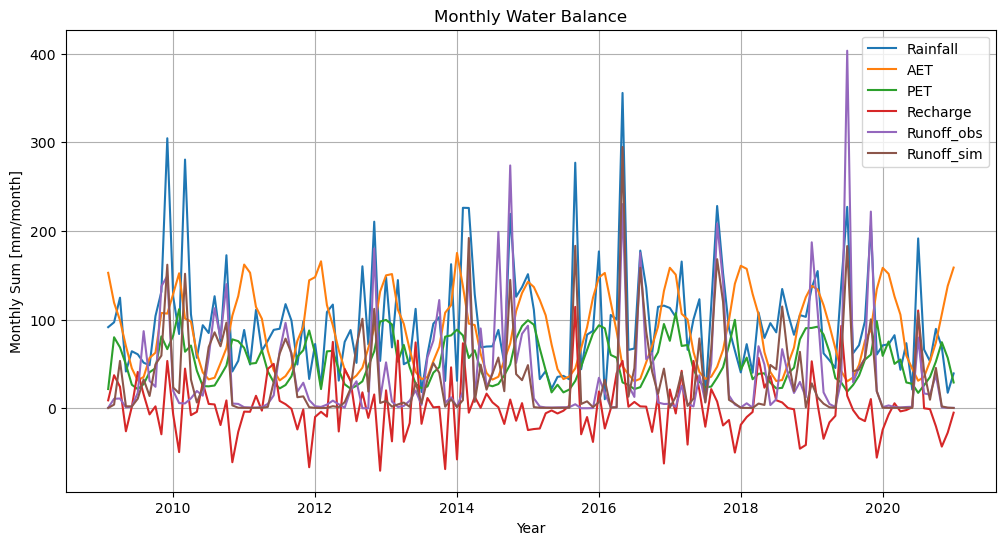

In [30]:
import matplotlib.pyplot as plt

# Supongamos que df_m es tu DataFrame mensual

# Configuración del gráfico
plt.figure(figsize=(12, 6))

# Línea para Precipitación
plt.plot(df_m['year'] + df_m['month'] / 12, df_m['precip'], label='Rainfall')

# Línea para ETP
plt.plot(df_m['year'] + df_m['month'] / 12, df_m['etp'], label='AET')

# Línea para ETR
plt.plot(df_m['year'] + df_m['month'] / 12, df_m['etr'], label='PET')

# Línea para Recarga
plt.plot(df_m['year'] + df_m['month'] / 12, df_m['recharge'], label='Recharge')

# Línea para Qobs
plt.plot(df_m['year'] + df_m['month'] / 12, df_m['qobs_mm_d'], label='Runoff_obs')

# Línea para Qsim
plt.plot(df_m['year'] + df_m['month'] / 12, df_m['qsim_mm_d'], label='Runoff_sim')

# Añadir etiquetas y título
plt.xlabel('Year')
plt.ylabel('Monthly Sum [mm/month]')
plt.title('Monthly Water Balance')
plt.legend()
plt.grid()
# Mostrar el gráfico
plt.show()


## Monthly clim

In [31]:
# Crear DataFrame mensual (df_m_clim)
df_m_clim = df_m.groupby(['month']).agg({
    'precip': 'mean',
    'etp': 'mean',
    'etr': 'mean',
    'recharge': 'mean',
    'qobs_mm_d': 'mean',
    'qsim_mm_d': 'mean',
    'qobs': 'mean',
    'qsim': 'mean',
    'qobs_esp': 'mean',
    'qsim_esp':'mean'
}).reset_index()

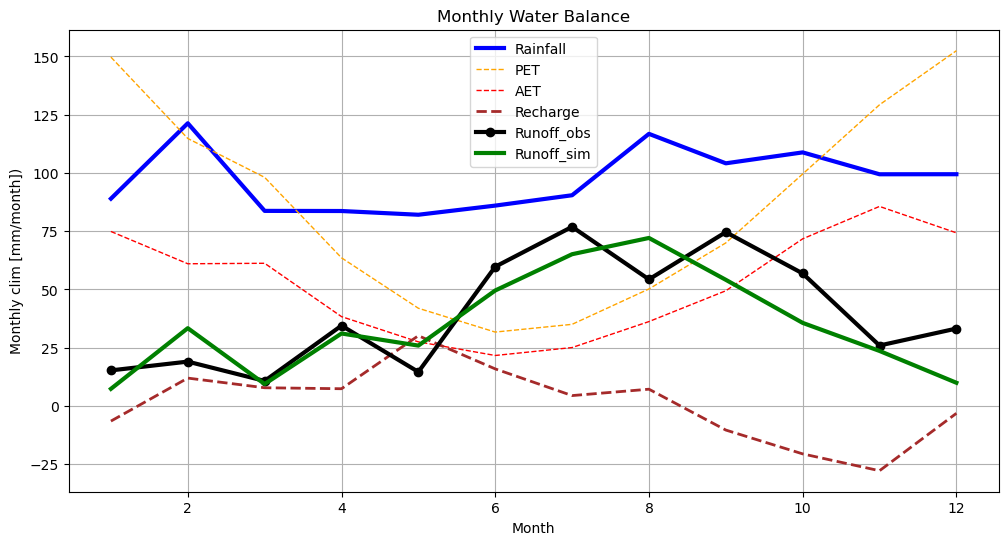

In [32]:
# Configuración del gráfico
plt.figure(figsize=(12, 6))

# Línea para Precipitación
plt.plot(df_m_clim['month'], df_m_clim['precip'], label='Rainfall',color='blue', ls = '-', lw=3)

# Línea para ETP
plt.plot(df_m_clim['month'], df_m_clim['etp'], label='PET', color='orange', ls = '--', lw=1)

# Línea para ETR
plt.plot(df_m_clim['month'], df_m_clim['etr'], label='AET', color='red', ls = '--', lw=1)

# Línea para Recarga
plt.plot(df_m_clim['month'], df_m_clim['recharge'], label='Recharge', color='brown', ls = '--', lw=2)

# Línea para Qobs
plt.plot(df_m_clim['month'], df_m_clim['qobs_mm_d'], label='Runoff_obs', color='black', ls = '-', lw=3, marker = 'o')

# Línea para Qsim
plt.plot(df_m_clim['month'], df_m_clim['qsim_mm_d'], label='Runoff_sim', color='green', ls = '-', lw=3)

# Añadir etiquetas y título
plt.xlabel('Month')
plt.ylabel('Monthly clim [mm/month])')
plt.title('Monthly Water Balance')
plt.legend()
plt.grid()
# Mostrar el gráfico
plt.show()

## Yearly sum

In [33]:
# Crear DataFrame anual (df_y)
df_y = df_all.groupby(['year']).agg({
    'precip': 'sum',
    'etp': 'sum',
    'etr': 'sum',
    'recharge': 'sum',
    'qobs_mm_d': 'sum',
    'qsim_mm_d': 'sum'
}).reset_index()

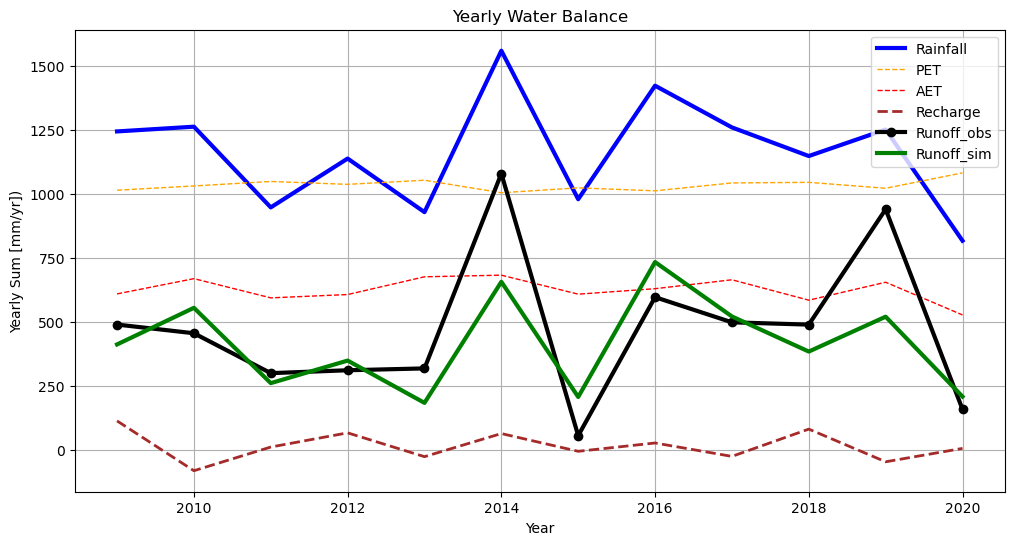

In [34]:
# Configuración del gráfico
plt.figure(figsize=(12, 6))

# Línea para Precipitación
plt.plot(df_y['year'], df_y['precip'], label='Rainfall', color='blue', ls = '-', lw=3)

# Línea para ETP
plt.plot(df_y['year'], df_y['etp'], label='PET',color='orange', ls = '--', lw=1)

# Línea para ETR
plt.plot(df_y['year'], df_y['etr'], label='AET', color='red', ls = '--', lw=1)

# Línea para Recarga
plt.plot(df_y['year'], df_y['recharge'], label='Recharge',color='brown', ls = '--', lw=2)

# Línea para Qobs
plt.plot(df_y['year'], df_y['qobs_mm_d'], label='Runoff_obs', color='black', ls = '-', lw=3, marker = 'o')

# Línea para Qsim
plt.plot(df_y['year'], df_y['qsim_mm_d'], label='Runoff_sim', color='green', ls = '-', lw=3)

# Añadir etiquetas y título
plt.xlabel('Year')
plt.ylabel('Yearly Sum [mm/yr])')
plt.title('Yearly Water Balance')
plt.legend()
plt.grid()
# Mostrar el gráfico
plt.show()


